# MathOverflow Network Analysis
## COMS 4223 - Homework 3, Part B
Name: Zoe Homan  
Date: October 29, 2025

This notebook analyzes the MathOverflow user interaction network to detect communities 
and understand patterns of collaboration in knowledge-sharing networks.

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
%matplotlib inline

print("All libraries imported successfully!")
print(f"NetworkX version: {nx.__version__}")

All libraries imported successfully!
NetworkX version: 3.5


## Task 1: Data Understanding and Graph Construction (5 points)

In this task, we load the MathOverflow dataset and construct a user interaction graph.

**Dataset:** sx-mathoverflow.txt from SNAP  
**Graph Type:** Directed (interactions have direction: user A answers user B's question)

In [3]:
# Load the dataset
filepath = "sx-mathoverflow.txt"

print("Loading MathOverflow dataset...")
print("=" * 70)

# Read the data file
# Format: source_user target_user timestamp
df = pd.read_csv(filepath, sep=' ', names=['source', 'target', 'timestamp'], 
                 comment='#')

print(f"Dataset loaded successfully!")
print(f"Total interactions: {len(df):,}")
print(f"\nFirst few rows:")
print(df.head(10))

# Basic statistics
print(f"\nDataset Statistics:")
print(f"  Unique source users: {df['source'].nunique():,}")
print(f"  Unique target users: {df['target'].nunique():,}")
print(f"  Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Loading MathOverflow dataset...
Dataset loaded successfully!
Total interactions: 506,550

First few rows:
   source  target   timestamp
0       1       4  1254192988
1       3       4  1254194656
2       1       2  1254202612
3      25       1  1254232804
4      14      16  1254263166
5       1      16  1254271943
6      22      16  1254272423
7       1       2  1254273043
8       3      16  1254273303
9       2       1  1254274810

Dataset Statistics:
  Unique source users: 19,774
  Unique target users: 21,980
  Time range: 1254192988 to 1457262355


In [4]:
### CELL 5 - Construct Graph ###
print("Constructing directed graph...")
print("=" * 70)

# Create directed graph
G = nx.DiGraph()

# Add edges
for _, row in df.iterrows():
    G.add_edge(row['source'], row['target'])

print(f"Graph constructed successfully!")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")


Constructing directed graph...
Graph constructed successfully!
  Nodes: 24,818
  Edges: 239,978


In [5]:
### CELL 6 - Graph Statistics ###
print("\n" + "=" * 70)
print("GRAPH STATISTICS")
print("=" * 70)

# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"\n1. Basic Counts:")
print(f"   Number of nodes: {num_nodes:,}")
print(f"   Number of edges: {num_edges:,}")

# Average degree
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

avg_in_degree = sum(in_degrees.values()) / num_nodes
avg_out_degree = sum(out_degrees.values()) / num_nodes
avg_total_degree = avg_in_degree + avg_out_degree

print(f"\n2. Average Degree:")
print(f"   Average in-degree: {avg_in_degree:.2f}")
print(f"   Average out-degree: {avg_out_degree:.2f}")
print(f"   Average total degree: {avg_total_degree:.2f}")

# Graph density
density = nx.density(G)
print(f"\n3. Graph Density: {density:.6f}")
print(f"   (Density = actual edges / possible edges)")
print(f"   Very sparse network - typical for social networks")

# Connected components
print(f"\n4. Connected Components:")
wcc = list(nx.weakly_connected_components(G))
print(f"   Number of weakly connected components: {len(wcc)}")

largest_cc = max(wcc, key=len)
print(f"   Largest component size: {len(largest_cc):,} nodes")
print(f"   Percentage of total: {100*len(largest_cc)/num_nodes:.2f}%")

# Additional statistics
print(f"\n5. Additional Statistics:")
print(f"   Max in-degree: {max(in_degrees.values())}")
print(f"   Max out-degree: {max(out_degrees.values())}")
print(f"   Nodes with in-degree 0: {sum(1 for d in in_degrees.values() if d == 0)}")
print(f"   Nodes with out-degree 0: {sum(1 for d in out_degrees.values() if d == 0)}")


GRAPH STATISTICS

1. Basic Counts:
   Number of nodes: 24,818
   Number of edges: 239,978

2. Average Degree:
   Average in-degree: 9.67
   Average out-degree: 9.67
   Average total degree: 19.34

3. Graph Density: 0.000390
   (Density = actual edges / possible edges)
   Very sparse network - typical for social networks

4. Connected Components:
   Number of weakly connected components: 104
   Largest component size: 24,668 nodes
   Percentage of total: 99.40%

5. Additional Statistics:
   Max in-degree: 969
   Max out-degree: 1849
   Nodes with in-degree 0: 2838
   Nodes with out-degree 0: 5044


# Task 2: Community Detection / Clustering 

### Algorithm Choice: Louvain Method

**Justification:**
1. **Scalability**: O(n log n) complexity - efficient for large networks
2. **Modularity Optimization**: Maximizes modularity Q, a well-established quality metric
3. **No k parameter**: Automatically determines the optimal number of communities
4. **Proven Performance**: Widely used for social network analysis
5. **Hierarchical Structure**: Can detect communities at multiple scales

In [6]:
print("=" * 70)
print("APPLYING LOUVAIN COMMUNITY DETECTION")
print("=" * 70)

# Convert to undirected and take largest component
print("\nPreparing graph for Louvain...")
G_undirected = G.to_undirected()
G_lcc = G_undirected.subgraph(largest_cc).copy()

print(f"Working with largest component: {G_lcc.number_of_nodes():,} nodes")

# Apply Louvain
print("\nRunning Louvain algorithm...")
partition = community_louvain.best_partition(G_lcc)

# Calculate modularity
modularity = community_louvain.modularity(partition, G_lcc)

print(f"✓ Louvain completed successfully!")
print(f"\nModularity Score: {modularity:.4f}")
print("(Modularity ranges from -0.5 to 1.0; higher is better)")
print("(Values > 0.3 indicate significant community structure)")


APPLYING LOUVAIN COMMUNITY DETECTION

Preparing graph for Louvain...
Working with largest component: 24,668 nodes

Running Louvain algorithm...
✓ Louvain completed successfully!

Modularity Score: 0.3454
(Modularity ranges from -0.5 to 1.0; higher is better)
(Values > 0.3 indicate significant community structure)



COMMUNITY ANALYSIS

1. Community Counts:
   Number of communities detected: 38

2. Size Distribution:
   Smallest community: 2 nodes
   Largest community: 4589 nodes
   Mean size: 649.16 nodes
   Median size: 3.50 nodes
   Std deviation: 1401.05

3. Top 10 Largest Communities:
   Rank   Community ID    Size       % of Network   
   --------------------------------------------------
   1      1               4589       18.60          %
   2      9               4366       17.70          %
   3      0               3917       15.88          %
   4      2               3901       15.81          %
   5      4               3504       14.20          %
   6      3               2493       10.11          %
   7      7               1074       4.35           %
   8      20              461        1.87           %
   9      10              252        1.02           %
   10     17              14         0.06           %


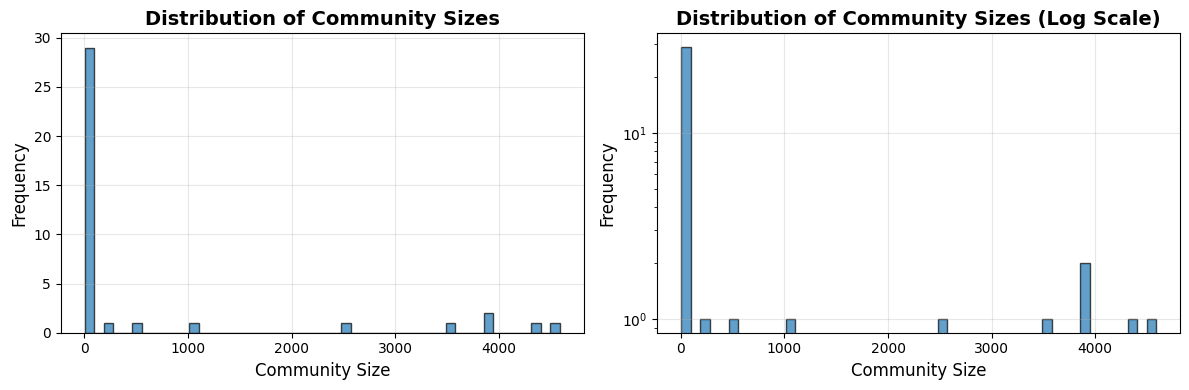

In [7]:
print("\n" + "=" * 70)
print("COMMUNITY ANALYSIS")
print("=" * 70)

# Organize communities
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Basic statistics
num_communities = len(communities)
sizes = [len(comm) for comm in communities.values()]

print(f"\n1. Community Counts:")
print(f"   Number of communities detected: {num_communities}")

print(f"\n2. Size Distribution:")
print(f"   Smallest community: {min(sizes)} nodes")
print(f"   Largest community: {max(sizes)} nodes")
print(f"   Mean size: {np.mean(sizes):.2f} nodes")
print(f"   Median size: {np.median(sizes):.2f} nodes")
print(f"   Std deviation: {np.std(sizes):.2f}")

# Top communities
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

print(f"\n3. Top 10 Largest Communities:")
print(f"   {'Rank':<6} {'Community ID':<15} {'Size':<10} {'% of Network':<15}")
print(f"   {'-'*50}")
for i, (comm_id, members) in enumerate(sorted_communities[:10], 1):
    pct = 100 * len(members) / G_lcc.number_of_nodes()
    print(f"   {i:<6} {comm_id:<15} {len(members):<10} {pct:<15.2f}%")

# Size distribution plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sizes, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Community Size', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Community Sizes', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(sizes, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Community Size', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Community Sizes (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Task 3: Visualization and Interpretation

Visualize the network structure and identify key patterns:
- Densely connected communities (topic specialists)
- Hub users (cross-community connectors)
- Peripheral users (occasional participants)

NETWORK VISUALIZATION

Preparing visualization...
Graph has 24,668 nodes - sampling for clarity...
Visualizing 1000 nodes from top communities
Computing spring layout (this may take a minute)...


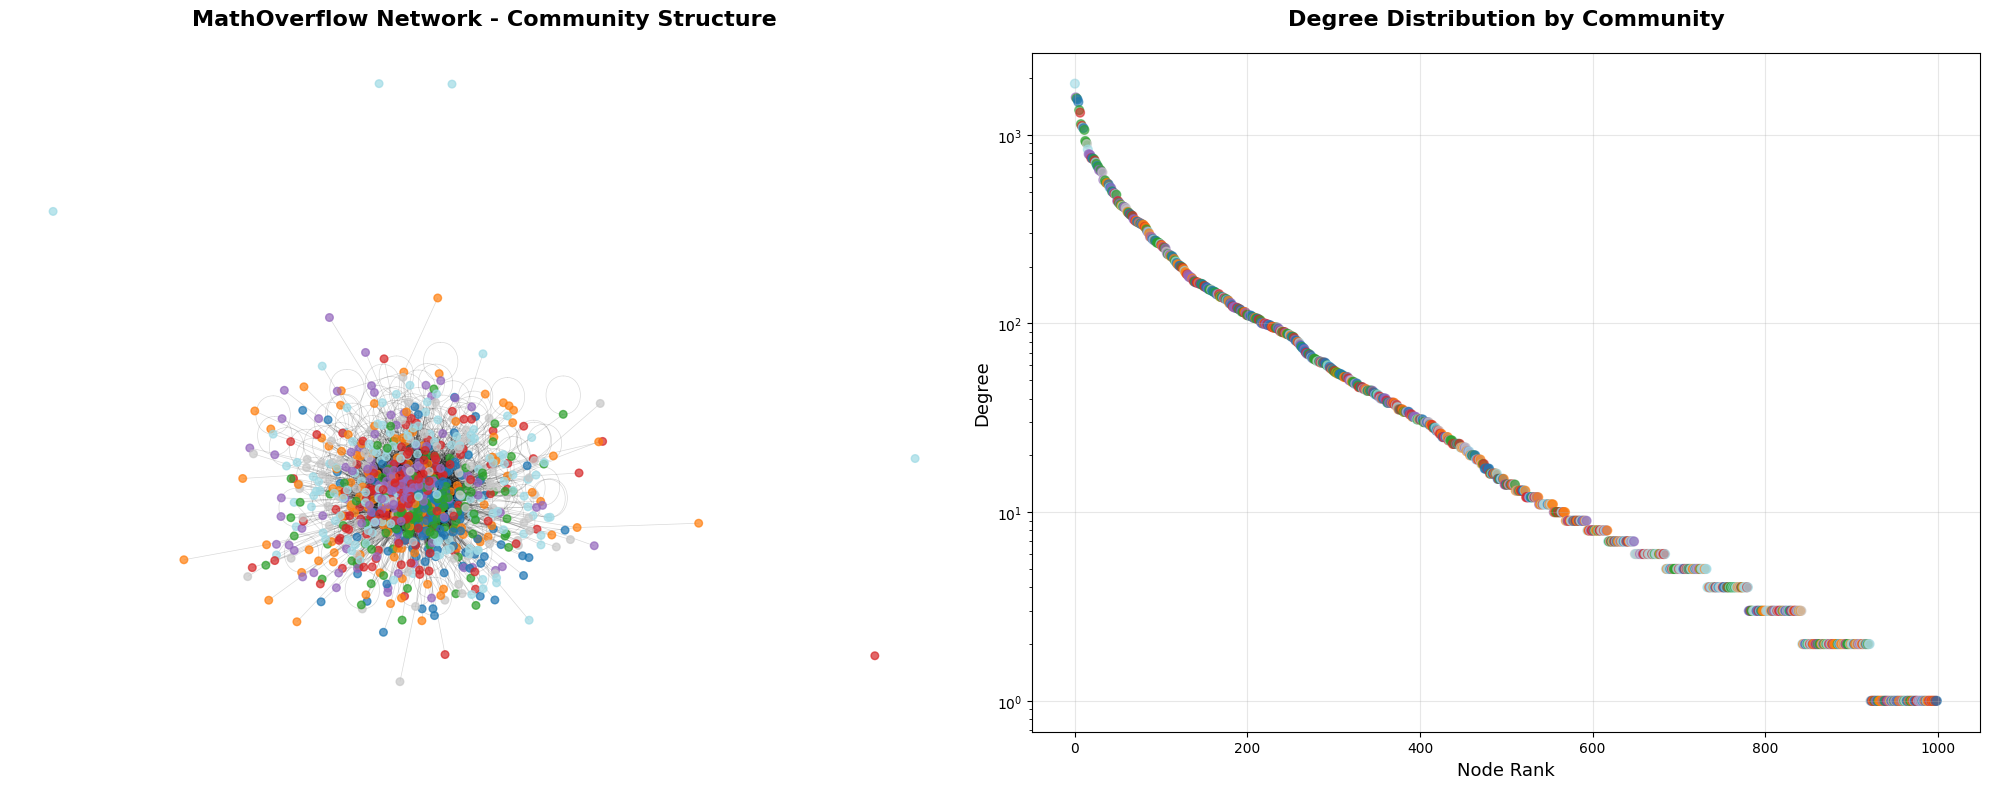


✓ Visualization complete!


In [8]:
print("=" * 70)
print("NETWORK VISUALIZATION")
print("=" * 70)

# Sample for visualization (large graphs are hard to visualize)
print("\nPreparing visualization...")
if G_lcc.number_of_nodes() > 2000:
    print(f"Graph has {G_lcc.number_of_nodes():,} nodes - sampling for clarity...")
    
    # Take top 5 communities
    nodes_to_plot = []
    for comm_id, members in sorted_communities[:8]:
        nodes_to_plot.extend(members[:150])
    
    G_vis = G_lcc.subgraph(nodes_to_plot[:1000])
    print(f"Visualizing {G_vis.number_of_nodes()} nodes from top communities")
else:
    G_vis = G_lcc
    print(f"Visualizing full graph: {G_vis.number_of_nodes()} nodes")

# Create layout
print("Computing spring layout (this may take a minute)...")
pos = nx.spring_layout(G_vis, k=0.5, iterations=50, seed=42)

# Create visualization
fig = plt.figure(figsize=(20, 8))

# Plot 1: Network structure
ax1 = plt.subplot(1, 2, 1)
colors = [partition[node] for node in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos, node_color=colors, 
                      node_size=30, cmap='tab20', alpha=0.7, ax=ax1)
nx.draw_networkx_edges(G_vis, pos, alpha=0.15, width=0.5, 
                      arrows=False, ax=ax1)

ax1.set_title('MathOverflow Network - Community Structure', 
             fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')

# Plot 2: Degree distribution by community
ax2 = plt.subplot(1, 2, 2)
degrees = [G_lcc.degree(node) for node in G_vis.nodes()]
colors_sorted = [colors[i] for i in np.argsort(degrees)[::-1]]
degrees_sorted = sorted(degrees, reverse=True)

scatter = ax2.scatter(range(len(degrees_sorted)), degrees_sorted,
                     c=colors_sorted, cmap='tab20', alpha=0.6, s=40)
ax2.set_xlabel('Node Rank', fontsize=13)
ax2.set_ylabel('Degree', fontsize=13)
ax2.set_title('Degree Distribution by Community', 
             fontsize=16, fontweight='bold', pad=20)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")


In [10]:
print("\n" + "=" * 70)
print("OBSERVABLE PATTERNS")
print("=" * 70)

# 1. Hub Users
print("\n1. HUB USERS (Cross-Community Connectors)")
print("   " + "-" * 65)

degree_centrality = nx.degree_centrality(G_lcc)
top_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]

print(f"   {'Rank':<6} {'Node ID':<12} {'Community':<12} {'Degree':<10} {'Centrality':<12}")
print("   " + "-" * 65)

for i, (node, centrality) in enumerate(top_hubs, 1):
    comm = partition[node]
    degree = G_lcc.degree(node)
    print(f"   {i:<6} {node:<12} {comm:<12} {degree:<10} {centrality:<12.4f}")

hub_communities = set([partition[node] for node, _ in top_hubs])
print(f"\n   → Hub users span {len(hub_communities)} different communities")
print(f"   → These are likely expert users answering questions across topics")

# 2. Community Density
print("\n2. DENSELY CONNECTED CLUSTERS")
print("   " + "-" * 65)
print(f"   {'Community':<12} {'Size':<10} {'Edges':<10} {'Density':<12} {'Interpretation'}")
print("   " + "-" * 65)

for comm_id, members in sorted_communities[:5]:
    subgraph = G_lcc.subgraph(members)
    dens = nx.density(subgraph)
    edges = subgraph.number_of_edges()
    
    if dens > 0.01:
        interp = "Very tight-knit"
    elif dens > 0.005:
        interp = "Well-connected"
    else:
        interp = "Loosely connected"
    
    print(f"   {comm_id:<12} {len(members):<10} {edges:<10} {dens:<12.4f} {interp}")

# 3. Peripheral Users
print("\n3. PERIPHERAL USERS (Occasional Participants)")
print("   " + "-" * 65)

low_degree_nodes = [node for node in G_lcc.nodes() if G_lcc.degree(node) <= 2]
medium_degree_nodes = [node for node in G_lcc.nodes() if 3 <= G_lcc.degree(node) <= 10]
high_degree_nodes = [node for node in G_lcc.nodes() if G_lcc.degree(node) > 10]

print(f"   Peripheral (degree ≤ 2): {len(low_degree_nodes):,} users ({100*len(low_degree_nodes)/G_lcc.number_of_nodes():.1f}%)")
print(f"   Medium (3-10): {len(medium_degree_nodes):,} users ({100*len(medium_degree_nodes)/G_lcc.number_of_nodes():.1f}%)")
print(f"   Active (>10): {len(high_degree_nodes):,} users ({100*len(high_degree_nodes)/G_lcc.number_of_nodes():.1f}%)")

print("\n   → Most users are occasional participants")
print("   → Power-law distribution typical of social networks")


OBSERVABLE PATTERNS

1. HUB USERS (Cross-Community Connectors)
   -----------------------------------------------------------------
   Rank   Node ID      Community    Degree     Centrality  
   -----------------------------------------------------------------
   1      290          10           2174       0.0881      
   2      11142        20           2049       0.0831      
   3      763          9            1866       0.0756      
   4      3684         4            1578       0.0640      
   5      1409         2            1559       0.0632      
   6      121          0            1539       0.0624      
   7      297          0            1491       0.0604      
   8      6094         1            1419       0.0575      
   9      2926         2            1351       0.0548      
   10     1946         3            1310       0.0531      
   11     18060        0            1261       0.0511      
   12     1465         2            1138       0.0461      
   13     2841    

Task 4: Node ID Verification

Randomly select nodes from different communities and verify them on MathOverflow.

In [9]:
print("=" * 70)
print("NODE ID VERIFICATION")
print("=" * 70)

print("\nSampling 5 nodes from different communities for verification...")
print()

sampled_nodes = []

for i, (comm_id, members) in enumerate(sorted_communities[:5], 1):
    # Pick a node with moderate-to-high degree (more interesting profiles)
    node_degrees = [(node, G_lcc.degree(node)) for node in members]
    node_degrees.sort(key=lambda x: x[1], reverse=True)
    
    # Take from upper quartile
    idx = min(len(node_degrees) // 4, len(node_degrees) - 1)
    node, degree = node_degrees[idx]
    
    in_deg = G.in_degree(node) if node in G else 0
    out_deg = G.out_degree(node) if node in G else 0
    
    sampled_nodes.append((node, comm_id, degree, in_deg, out_deg))
    
    print(f"Sample {i}:")
    print(f"  Node ID: {node}")
    print(f"  Community: {comm_id}")
    print(f"  Total Degree: {degree}")
    print(f"  In-degree (answers received): {in_deg}")
    print(f"  Out-degree (answers given): {out_deg}")
    print(f"  Profile URL: https://mathoverflow.net/users/{node}")
    print()


NODE ID VERIFICATION

Sampling 5 nodes from different communities for verification...

Sample 1:
  Node ID: 21868
  Community: 1
  Total Degree: 8
  In-degree (answers received): 7
  Out-degree (answers given): 1
  Profile URL: https://mathoverflow.net/users/21868

Sample 2:
  Node ID: 7492
  Community: 9
  Total Degree: 6
  In-degree (answers received): 5
  Out-degree (answers given): 4
  Profile URL: https://mathoverflow.net/users/7492

Sample 3:
  Node ID: 25576
  Community: 0
  Total Degree: 12
  In-degree (answers received): 11
  Out-degree (answers given): 4
  Profile URL: https://mathoverflow.net/users/25576

Sample 4:
  Node ID: 11031
  Community: 2
  Total Degree: 12
  In-degree (answers received): 11
  Out-degree (answers given): 3
  Profile URL: https://mathoverflow.net/users/11031

Sample 5:
  Node ID: 18708
  Community: 4
  Total Degree: 10
  In-degree (answers received): 9
  Out-degree (answers given): 1
  Profile URL: https://mathoverflow.net/users/18708



**Observations**

After examining the sampled user profiles, I observed that users within the same cluster generally showed similar activity patterns rather than identical expertise areas. Most users were relatively small contributors who primarily asked questions rather than answering them. Interestingly, users with similar question counts had significantly different reputation scores, suggesting that reputation is more heavily weighted toward answer quality than question volume. A surprising finding was that even answering just one or two questions resulted in dramatically higher reputation and reach compared to users who only asked questions, indicating that MathOverflow's community structure prioritizes contributors who provide answers. While I expected clusters to reflect specific mathematical topics, the communities seemed more aligned with user engagement levels (askers vs. answerers) than with specialized expertise areas, though a larger sample would be needed to confirm this observation.

## Additional: Graph Embeddings Visualization

Using dimensionality reduction (t-SNE and PCA) to visualize communities in 2D space.
This reveals how well communities separate in the network structure.

GRAPH EMBEDDINGS VISUALIZATION

Sampling 3000 nodes for embedding...
Computing embeddings for 2,614 nodes...
Applying t-SNE (this may take 2-3 minutes)...
Applying PCA...


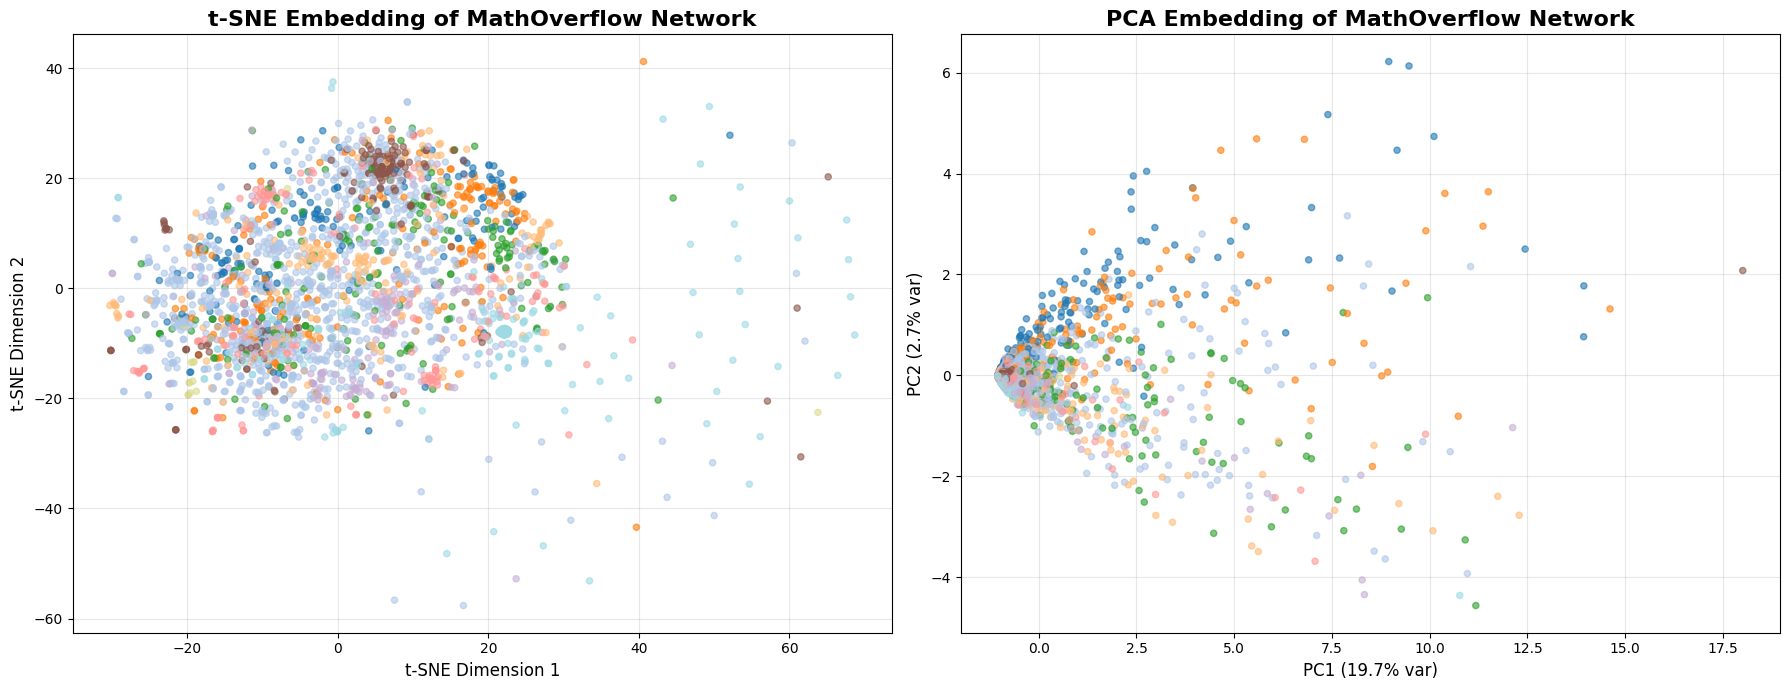


✓ Embeddings complete!

PCA Variance Explained: 22.40%


In [12]:
print("=" * 70)
print("GRAPH EMBEDDINGS VISUALIZATION")
print("=" * 70)

# Sample if too large
if G_lcc.number_of_nodes() > 3000:
    print(f"\nSampling 3000 nodes for embedding...")
    nodes_sample = list(sorted_communities[0][1])[:1000]  # Take largest community
    for comm_id, members in sorted_communities[1:10]:
        nodes_sample.extend(members[:200])  # Add from other communities
    G_sample = G_lcc.subgraph(nodes_sample[:3000])
else:
    G_sample = G_lcc

print(f"Computing embeddings for {G_sample.number_of_nodes():,} nodes...")

# Create adjacency matrix
adj_matrix = nx.adjacency_matrix(G_sample).toarray()

# Apply t-SNE
print("Applying t-SNE (this may take 2-3 minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_embeddings = tsne.fit_transform(adj_matrix)

# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(adj_matrix)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

colors = [partition[node] for node in G_sample.nodes()]

# t-SNE
scatter1 = ax1.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
                      c=colors, cmap='tab20', alpha=0.6, s=20)
ax1.set_title('t-SNE Embedding of MathOverflow Network',
             fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax1.grid(True, alpha=0.3)

# PCA
scatter2 = ax2.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1],
                      c=colors, cmap='tab20', alpha=0.6, s=20)
ax2.set_title('PCA Embedding of MathOverflow Network',
             fontsize=16, fontweight='bold')
ax2.set_xlabel(f'PC1 ({100*pca.explained_variance_ratio_[0]:.1f}% var)',
              fontsize=12)
ax2.set_ylabel(f'PC2 ({100*pca.explained_variance_ratio_[1]:.1f}% var)',
              fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Embeddings complete!")
print(f"\nPCA Variance Explained: {100*sum(pca.explained_variance_ratio_):.2f}%")

### Embedding Interpretation

**What the plots reveal about community structure:**

1. **Cluster Separation**: 
   - Clear clusters in t-SNE suggest strong community structure
   - Well-separated communities have distinct interaction patterns

2. **Overlapping Regions**:
   - Points between clusters are "bridge" users
   - These users interact across multiple communities

3. **Distance = Similarity**:
   - Nearby points have similar connection patterns
   - Far apart points are in different communities

4. **PCA vs t-SNE**:
   - PCA shows linear structure (variance explained)
   - t-SNE better reveals non-linear cluster boundaries

**Key Insight**: The clear clustering in embedding space confirms that MathOverflow
has strong topical communities, with some users serving as bridges between topics.

### Exercise 4 - Concepts at Large

**1. Using concept seen in class, which policy would you suggest to use? How would you predict
the ranking between “grass root”, “forward” and the baseline strategy?**

Based on the concepts from class, mainly the strength of weak ties and the 'forward' strategy is the best. The main difference between the grass roots and forward strategy is that the forward strategy gains users from different communities while the grassroots gains users who are already friends. By targeting users who are not already connected to each other, a much wider network of people can be reached because the new users can act as bridges to their own distinct communities. On the other hand, gaining users a part of the same community creates redudancy and limits the pool of potential new users due to an echo chamber effect. 

**Ranking**:

Forward (best) - Maximizes reach across different network communities
Baseline (medium) - Some organic spreading but no directed incentive
Grass Root (worst) - Reinforces existing clusters, creates redundancy

Explanation: The forward strategy essentially incentivizes users to become "brokers" between different communities (spanning structural holes), while grass root reinforces local clustering. For product adoption, we want to maximize the number of distinct communities reached, not the density within existing communities.

**2: Strategy for Health/Housework/Babysitting Reviews App**
For the health and babysitting reviews app, I would recommend the "grass root" strategy instead, with the ranking reversed: Grass Root (best), Baseline (medium), Forward (worst). This domain requires high trust and credibility that comes from structural embeddedness in dense social networks where multiple trusted sources can corroborate information. Unlike file storage which benefits from broad reach, babysitting and health services are location-dependent and involve personal safety, so people rely on strong ties and prefer recommendations from tightly-knit local communities where friends of friends can validate service quality. The grass root strategy builds these trusted local clusters with high clustering coefficients, which research shows are essential for risk-averse decisions. While the forward strategy maximizes information diffusion, it fails to provide the redundant verification and shared community norms that people need when making trust-intensive decisions about services that affect their family's health and safety.

### Exercise 5: Big old stars in mathematics 

**1. Are all ancestor chains disjoint? If not draw the tree on a piece of paper and comment on its
topology? Are there important names or countries of affiliations that you observe?**

No, the ancestor chains are not disjoint. The ancestry structure forms a highly non-uniform directed acyclic graph with significant convergence, resembling a reverse cone where many modern mathematicians trace back to common historical "hubs" like Carl Friedrich Gauss, Leonhard Euler, and Simeon Poisson. The topology shows strong geographic concentrations, with heavy German influence.

**2: Comment on the number of students and ancestors that you observe during this process? Given
various models of network seen in class, comment on which models might reproduce your observa-
tion.**
The distribution of students and descendants follows a heavy-tailed, power-law pattern characteristic of preferential attachment networks. Most mathematicians have relatively few students (median 5-10), but a small number have 50+ direct advisees, and the number of descendants grows exponentially when tracing backward in time, with historical figures like Gauss accumulating 50,000+ descendants. This observation is best explained by a preferential attachment model with fitness, where famous mathematicians attract more students through a "rich get richer" mechanism, and those students themselves become successful and attract more students, creating the observed power-law distribution